<a href="https://colab.research.google.com/github/colaprograms/2019-hackathon-ocr-wymbah/blob/master/notebooks/ctc_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import os, torch, re, sys
import numpy as np
import matplotlib.pyplot as p
import random, PIL

In [4]:
torch

<module 'torch' from '/home/gibson/sdb2/cola/ass/speechify_env/lib/python3.7/site-packages/torch/__init__.py'>

In [5]:
"""os.chdir("/content")
if not os.path.exists("/content/AI4Good---Meza-OCR-Challenge"):
  !git clone https://github.com/Charitable-Analytics-International/AI4Good---Meza-OCR-Challenge
if not os.path.exists("/content/2019-hackathon-ocr-wymbah"):
  !git clone https://github.com/colaprograms/2019-hackathon-ocr-wymbah
os.chdir("/content/2019-hackathon-ocr-wymbah")
!git pull"""

os.chdir("/home/gibson/sdb2/cola/ass/balls/2019-hackathon-ocr-wymbah")
from importlib import reload
import util.file
reload(util.file)

"""from google.colab import drive
drive.mount("/content/gdrive")
try:
  os.mkdir("/content/gdrive/My Drive/code")
except:
  pass
try:
  os.mkdir("/content/gdrive/My Drive/code/checkpoint")
except:
  pass"""

Using path ../AI4Good---Meza-OCR-Challenge
Using path ../AI4Good---Meza-OCR-Challenge


'from google.colab import drive\ndrive.mount("/content/gdrive")\ntry:\n  os.mkdir("/content/gdrive/My Drive/code")\nexcept:\n  pass\ntry:\n  os.mkdir("/content/gdrive/My Drive/code/checkpoint")\nexcept:\n  pass'

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


14


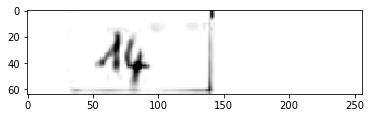

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


-11.076668 0.29998773 1.9868216e-08 1.0


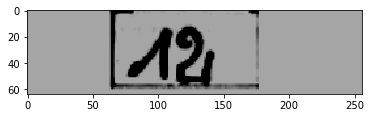

In [11]:
from util.file import FileHolder
fh = FileHolder()
inp, outp = fh.get_batch(1, dontclip=False)

for file, val in zip(inp, outp):
  print(val)
  p.imshow(file)
  p.show()

def to_tensor(buf):
  #buf -= 0.5
  #buf *= 2
  #buf -= np.min(buf, axis=(0, 1, 2))[None, None, None, :]
  #buf /= np.max(buf, axis=(0, 1, 2))[None, None, None, :]
  #buf = (buf - 0.5) * 2
  buf -= np.mean(buf, axis=(0, 1, 2))[None, None, None, :]
  buf /= np.std(buf, axis=(0, 1, 2))[None, None, None, :]
  #buf -= np.array([0.485, 0.456, 0.406])[None, None, None, :]
  #buf /= np.array([0.229, 0.224, 0.225])[None, None, None, :]
  return torch.tensor(buf, dtype=torch.float32).permute(0, 3, 1, 2)

def get_batch(batchsize, validation=False):
  inp, outp = fh.get_batch(batchsize, validation, dontclip=False)
  inp = np.stack(inp)
  inp = to_tensor(inp)
  return inp, outp

b = get_batch(1)[0].numpy().squeeze().transpose(1, 2, 0)
print(np.min(b), np.max(b), np.mean(b), np.std(b))
p.imshow(get_batch(1)[0].numpy().squeeze().transpose(1, 2, 0) * 0.5 + 0.5)
p.show()

In [12]:
import torch.nn as nn
import torch.optim as optim
import torchvision
np.set_printoptions(4, suppress=True)

In [ ]:
import util.chars
reload(util.chars)
from util.chars import chars, nchars, idx, input_to_string

ntraining = len(fh.info['training'])

BATCH_SIZE = 64

def maketarget(outputs):
  classes = []
  for string in outputs:
    classes.extend([idx[c] for c in string])
    lengths = [len(string) for string in outputs]
  return torch.tensor(classes, dtype=torch.int32), torch.tensor(lengths, dtype=torch.int32)

trainloss = []
validloss = []
import nets.ctcneu
reload(nets.ctcneu)
from nets.ctcneu import CTCModel
  
def run():
  """resnet = torchvision.models.resnet.resnet34(True)

  "Cut off the last two layers"
  def forward(self, x):
    x = self.conv1(x)
    x = self.bn1(x)
    x = self.relu(x)
    x = self.maxpool(x)

    x = self.layer1(x)
    x = self.layer2(x)
    x = self.layer3(x)
    #x = self.layer4(x)

    return x

  import types
  resnet.forward = types.MethodType(forward, resnet)
  resnet = resnet.cuda()
  for param in resnet.parameters():
    param.requires_grad = False
  """
  ctcmodel = CTCModel().cuda()
  ctc = nn.CTCLoss(reduction='sum').cuda()
  optimizer = optim.SGD(ctcmodel.parameters(), lr=0.0001, momentum=0.9, nesterov=True, weight_decay=1e-3)
  scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=6, verbose=True)
  
  def input_to_string(inp):
    assert inp.shape[0] == 1
    if isinstance(inp, torch.Tensor):
      inp = inp.clone().detach().cpu().numpy()
    def randchoice(p):
      p = np.exp(p)
      u = random.random()
      #print(p)
      for i in range(p.shape[0]):
        u -= p[i]
        if u < 1e-6:
          return i
      raise Exception("not a probability distribution")
    return "".join(chars[randchoice(inp[0, j, :])] for j in range(inp.shape[1]))
  printed = [False]
  def crunch(inp, outp):
    inp = ctcmodel(inp.clone().cuda())
    inp = inp.permute(1, 0, 2)
    assert inp.shape[0] == 32
    input_lengths = [32 for i in range(inp.shape[1])]
    target, target_lengths = maketarget(outp)
    #input_lengths, target_lengths = map(tuple, [input_lengths, target_lengths])
    input_lengths = torch.tensor(input_lengths, dtype=torch.int32)
    target_lengths = target_lengths
    #if not printed[0]:
      #print(target)
    #  printed[0] = True
    loss = ctc(inp, target, input_lengths, target_lengths)
    if not printed[0] and loss.item() < 1e-4:
        print("small")
        for j in range(inp.shape[1]):
          inp_ = inp[:, j, :].clone().detach().cpu().numpy()
          print("%d:" % j, input_to_string(inp_[None, :, :]), outp[j])
          print("%d:" % j, np.exp(inp_))
        print(target)
        print(input_lengths)
        print(target_lengths)
        printed[0] = True
    return loss
  #inp, outp = get_batch(BATCH_SIZE)
  for epoch in range(999999):
    running_loss = 0.0
    length = 0
    #print("Example output:")
    for i in range(100):
      inp, outp = get_batch(BATCH_SIZE)
      optimizer.zero_grad()
      loss = crunch(inp, outp)
      loss.backward()
      optimizer.step()
      running_loss += loss.item()
      length += BATCH_SIZE
    loss = None
    trainingloss = running_loss / length
    print("Epoch %d. Loss: %f" % (epoch, trainingloss))
    trainloss.append(trainingloss)
    running_loss = 0.0
    length = 0
    with torch.no_grad():
      for i in range(100):
        inp, outp = get_batch(BATCH_SIZE, validation=True)
        if i == 0:
          pass
          #log = ctcmodel(inp)
          #for j in range(BATCH_SIZE):
          #  string = input_to_string(log[j:j+1, :, :])
          #  print(j, "[%s]"%string, outp[j])
        loss = crunch(inp, outp)
        running_loss += loss.item()
        length += BATCH_SIZE
    validationloss = running_loss / length
    scheduler.step(validationloss)
    print("Validation loss: %f" % validationloss)
    validloss.append(validationloss)
    file = "checkpoint/checkpoint-%04d-%.2f" % (epoch, validationloss)
    torch.save({
        'ctcmodel': ctcmodel.state_dict(),
        'trainloss': trainloss,
        'validloss': validloss
    }, file)
    print("Saved", file)

run()

In [ ]:
image_tensor = torch.Tensor(image)
image_tensor = torch.unsqueeze(image_tensor, 0)
image_tensor = image_tensor.permute(0, 3, 1, 2)
out = resnet(image_tensor)
print(out)
print(out.shape)

In [0]:
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
'
7878787878787878787878787878787878787878787878787878787878787878787878787878787878787878787878787878787878787878787878787878787878787878787878787878787878787878[pppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppmjnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx]'''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''